In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout
from plotly.offline import iplot
from sklearn.metrics import mean_squared_error, mean_absolute_error


2023-02-22 09:41:39.395074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 09:41:39.511305: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-22 09:41:39.511327: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-22 09:41:40.141417: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
df=pd.read_csv('train.csv')
df

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume Currency
0,1676588400000,2023-02-16 23:00:00,BTC/USD,24002.33,24098.56,23515.96,23520.73,48.328991,1.136733e+06
1,1676584800000,2023-02-16 22:00:00,BTC/USD,24521.00,24555.40,24000.00,24002.33,41.758527,1.002302e+06
2,1676581200000,2023-02-16 21:00:00,BTC/USD,24562.44,24575.06,24364.72,24521.00,44.653526,1.094949e+06
3,1676577600000,2023-02-16 20:00:00,BTC/USD,24876.29,24886.09,24454.89,24562.44,108.987269,2.676993e+06
4,1676574000000,2023-02-16 19:00:00,BTC/USD,24979.87,24999.77,24846.43,24876.29,50.910118,1.266455e+06
...,...,...,...,...,...,...,...,...,...
64515,1444323600,2015-10-08 17:00:00,BTC/USD,244.25,244.99,244.02,244.99,3.920632,9.605156e+02
64516,1444320000,2015-10-08 16:00:00,BTC/USD,244.92,244.92,244.25,244.25,3.895252,9.514154e+02
64517,1444316400,2015-10-08 15:00:00,BTC/USD,245.00,245.00,244.92,244.92,3.016926,7.389055e+02
64518,1444312800,2015-10-08 14:00:00,BTC/USD,245.00,245.00,244.50,245.00,4.453649,1.091144e+03


In [3]:
# from datetime import datetime
# df['Date'] = pd.to_datetime(df['Timestamp'], unit = 's')
# df = df.sort_values('Date')
# groups = pd.factorize(df['Date'].dt.day.astype(str) + '_' + df['Date'].dt.month.astype(str) + '_' + df['Date'].dt.year.astype(str))[0]

In [4]:
### Calculate vwap
df['Vwap'] = (df['Volume BTC']*(df['High']+df['Low'])/2).cumsum() / df['Volume BTC'].cumsum()
### Sort time
df = df.sort_values("Date")
### Set index
btc = df.set_index("Date")
btc

,Unix,Symbol,Open,High,Low,Close,Volume BTC,Volume Currency,Vwap
Date,,,,,,,,,
2015-10-08 13:00:00,1444309200,BTC/USD,0.00,245.00,0.00,245.00,0.606654,1.486303e+02,11329.893700
2015-10-08 14:00:00,1444312800,BTC/USD,245.00,245.00,244.50,245.00,4.453649,1.091144e+03,11329.894537
2015-10-08 15:00:00,1444316400,BTC/USD,245.00,245.00,244.92,244.92,3.016926,7.389055e+02,11329.900619
2015-10-08 16:00:00,1444320000,BTC/USD,244.92,244.92,244.25,244.25,3.895252,9.514154e+02,11329.904739
2015-10-08 17:00:00,1444323600,BTC/USD,244.25,244.99,244.02,244.99,3.920632,9.605156e+02,11329.910059
...,...,...,...,...,...,...,...,...,...
2023-02-16 19:00:00,1676574000000,BTC/USD,24979.87,24999.77,24846.43,24876.29,50.910118,1.266455e+06,24486.473072
2023-02-16 20:00:00,1676577600000,BTC/USD,24876.29,24886.09,24454.89,24562.44,108.987269,2.676993e+06,24395.270174
2023-02-16 21:00:00,1676581200000,BTC/USD,24562.44,24575.06,24364.72,24521.00,44.653526,1.094949e+06,24172.654582


In [5]:
btc.isna().sum()

Unix               0
Symbol             0
Open               0
High               0
Low                0
Close              0
Volume BTC         0
Volume Currency    0
Vwap               0
dtype: int64

In [6]:
btc.dropna(axis=0,inplace=True)
btc.drop(columns=['Unix', 'Symbol', 'Volume Currency'],axis=1,inplace=True)
btc

,Open,High,Low,Close,Volume BTC,Vwap
Date,,,,,,
2015-10-08 13:00:00,0.00,245.00,0.00,245.00,0.606654,11329.893700
2015-10-08 14:00:00,245.00,245.00,244.50,245.00,4.453649,11329.894537
2015-10-08 15:00:00,245.00,245.00,244.92,244.92,3.016926,11329.900619
2015-10-08 16:00:00,244.92,244.92,244.25,244.25,3.895252,11329.904739
2015-10-08 17:00:00,244.25,244.99,244.02,244.99,3.920632,11329.910059
...,...,...,...,...,...,...
2023-02-16 19:00:00,24979.87,24999.77,24846.43,24876.29,50.910118,24486.473072
2023-02-16 20:00:00,24876.29,24886.09,24454.89,24562.44,108.987269,24395.270174
2023-02-16 21:00:00,24562.44,24575.06,24364.72,24521.00,44.653526,24172.654582


In [7]:
print(list(btc))

['Open', 'High', 'Low', 'Close', 'Volume BTC', 'Vwap']


In [8]:
# btc[['Open', 'High', 'Low', 'Close', 'Volume BTC', 'Vwap']]=scaler.fit_transform(btc[['Open', 'High', 'Low', 'Close', 'Volume BTC', 'Vwap']])

In [9]:
scalerY = MinMaxScaler(feature_range=(0,1))
y = btc[['Close']]
y = y.values
y = scalerY.fit_transform(y)
y

array([[2.04698234e-05],
       [2.04698234e-05],
       [1.93001192e-05],
       ...,
       [3.54967207e-01],
       [3.47383576e-01],
       [3.40341957e-01]])

In [10]:
scalerX = MinMaxScaler(feature_range=(0,1))
X = btc.drop(columns=['Close'],axis=1)
X = scalerX.fit_transform(X)
X

array([[0.00000000e+00, 2.03617409e-05, 0.00000000e+00, 7.11471904e-05,
        0.00000000e+00],
       [3.56950541e-03, 2.03617409e-05, 3.57049292e-03, 5.22314878e-04,
        3.12002439e-08],
       [3.56950541e-03, 2.03617409e-05, 3.57662628e-03, 3.53818918e-04,
        2.57753131e-07],
       ...,
       [3.57860255e-01, 3.53879203e-01, 3.55803928e-01, 5.23687457e-03,
        4.78383214e-01],
       [3.57256499e-01, 3.53593265e-01, 3.50477833e-01, 4.89735500e-03,
        4.72895276e-01],
       [3.49699783e-01, 3.46948939e-01, 3.43409279e-01, 5.66792561e-03,
        4.64772540e-01]])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
X_train=np.array(X_train)
X_test = np.array(X_test)

X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

y_train=np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

2023-02-22 09:41:41.286631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-22 09:41:41.286671: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-22 09:41:41.286693: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (BakanPC): /proc/driver/nvidia/version does not exist
2023-02-22 09:41:41.287170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 5, 50)             20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(X_train,y_train,verbose=1,epochs=15,batch_size=128)

Epoch 1/15
404/404 [==============================] - 9s 8ms/step - loss: 0.0017
Epoch 2/15
404/404 [==============================] - 3s 8ms/step - loss: 3.2859e-05
Epoch 3/15
404/404 [==============================] - 3s 8ms/step - loss: 2.2252e-05
Epoch 4/15
404/404 [==============================] - 3s 8ms/step - loss: 1.5813e-05
Epoch 5/15
404/404 [==============================] - 4s 10ms/step - loss: 1.4529e-05
Epoch 6/15
404/404 [==============================] - 3s 8ms/step - loss: 1.2087e-05
Epoch 7/15
404/404 [==============================] - 3s 8ms/step - loss: 1.1294e-05
Epoch 8/15
404/404 [==============================] - 3s 8ms/step - loss: 1.1291e-05
Epoch 9/15
404/404 [==============================] - 3s 8ms/step - loss: 9.7837e-06
Epoch 10/15
404/404 [==============================] - 3s 8ms/step - loss: 1.1141e-05
Epoch 11/15
404/404 [==============================] - 4s 10ms/step - loss: 1.3249e-05
Epoch 12/15
404/404 [==============================] - 4s 9ms/ste

<Axes: >

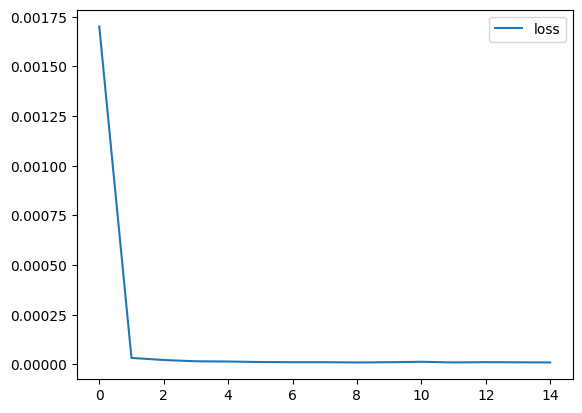

In [13]:
losses=pd.DataFrame(model.history.history)
losses.plot()

In [14]:
trainPredict = model.predict(X_train)
trainPredict

1613/1613 [==============================] - 4s 2ms/step


array([[-0.00429956],
       [-0.00183692],
       [-0.00184355],
       ...,
       [ 0.72004616],
       [ 0.7192109 ],
       [ 0.7202242 ]], dtype=float32)

In [15]:
testPredict = model.predict(X_test)
testPredict

404/404 [==============================] - 2s 2ms/step


array([[0.7202054 ],
       [0.7200892 ],
       [0.7194981 ],
       ...,
       [0.35785502],
       [0.35664007],
       [0.34929603]], dtype=float32)

In [16]:
testPredict = scalerY.inverse_transform(testPredict)
testY = scalerY.inverse_transform(y_test)
trainPredict = scalerY.inverse_transform(trainPredict)
trainY = scalerY.inverse_transform(y_train)

In [17]:
trainPredict

array([[  -50.4612 ],
       [  117.96654],
       [  117.51353],
       ...,
       [49489.977  ],
       [49432.85   ],
       [49502.152  ]], dtype=float32)

In [18]:
testPredict

array([[49500.867],
       [49492.918],
       [49452.492],
       ...,
       [24718.506],
       [24635.412],
       [24133.129]], dtype=float32)

In [19]:
mse_train = mean_squared_error(trainPredict, trainY)
mae_train = mean_absolute_error(trainPredict, trainY)
rmse_train = math.sqrt(mse_train)
print('MSE train: {0}, MAE train: {1}, RMSE train: {2}'.format(mse_train, mae_train, rmse_train))

MSE train: 45860.14691176113, MAE train: 121.1599351838801, RMSE train: 214.1498235155965


In [20]:
mse_test = mean_squared_error(testPredict, testY)
mae_test = mean_absolute_error(testPredict, testY)
rmse_test = math.sqrt(mse_test)
print('MSE test: {0}, MAE test: {1}, RMSE test: {2}'.format(mse_test, mae_test, rmse_test))

MSE test: 255069.09901999068, MAE test: 392.7467627255841, RMSE test: 505.043660508664


In [21]:
mse = mean_squared_error(np.concatenate((trainPredict, testPredict)), np.concatenate((trainY, testY)))
mae = mean_absolute_error(np.concatenate((trainPredict, testPredict)), np.concatenate((trainY, testY)))
rmse = math.sqrt(mse)
print('MSE: {0}, MAE: {1}, RMSE: {2}'.format(mse, mae, rmse))

MSE: 87701.93733340706, MAE: 175.4773006922209, RMSE: 296.14512883619585


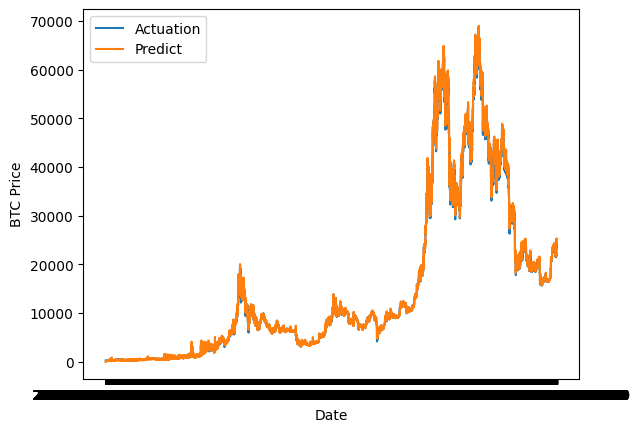

In [22]:
date_array = np.array(df['Date'])
plt.plot(date_array, np.concatenate((trainY, testY)), label='Actuation')
plt.plot(date_array, np.concatenate((trainPredict, testPredict)), label='Predict')
plt.legend(loc='best')
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.show()

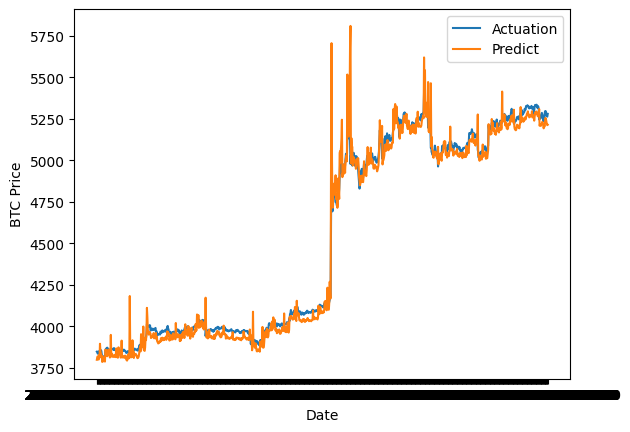

In [23]:
date_array = np.array(df['Date'])
plt.plot(date_array[30000:31000], trainY[30000:31000], label='Actuation')
plt.plot(date_array[30000:31000], trainPredict[30000:31000], label='Predict')
plt.legend(loc='best')
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.show()

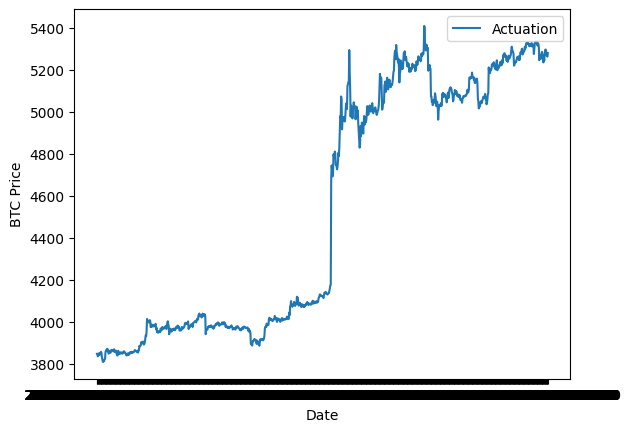

In [24]:
date_array = np.array(df['Date'])
plt.plot(date_array[30000:31000], trainY[30000:31000], label='Actuation')
plt.legend(loc='best')
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.show()

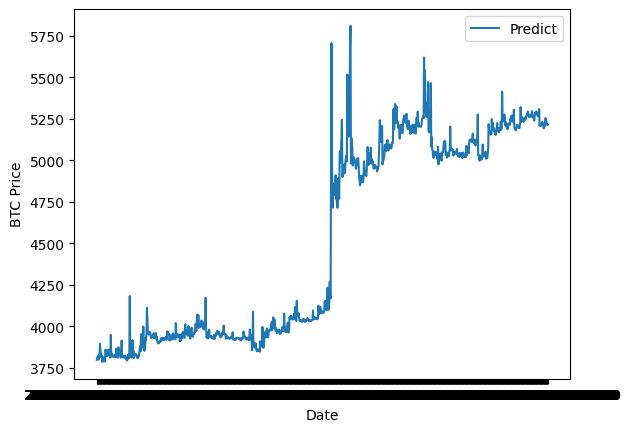

In [25]:
date_array = np.array(df['Date'])
plt.plot(date_array[30000:31000], trainPredict[30000:31000], label='Predict')
plt.legend(loc='best')
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.show()

In [26]:
# from tensorflow.keras.models import save_model
# save_model(model, "btc-predict-model.h5")